<a href="https://colab.research.google.com/github/RH00000/Rice_LLM_Replicability_Project/blob/main/recalibration_for_trial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, brier_score_loss
from matplotlib import pyplot as plt

In [2]:
#Upload CSV File
from google.colab import files
uploaded = files.upload()

Saving prompt_5_ensembling_trial_3.csv to prompt_5_ensembling_trial_3.csv


In [4]:
# Load and validate
df = pd.read_csv("prompt_5_ensembling_trial_3.csv")

if "result_binary" not in df.columns:
    raise KeyError("Column 'result_binary' not found.")

In [5]:
# Required columns
prompt_cols = [
    "sample_size_prob",
    "p_value_prob",
    "method_complexity_prob",
    "author_citation_prob",
    "subfield_prob"
]
for c in prompt_cols + ["result_binary"]:
    if c not in df.columns:
        raise KeyError(f"Missing required column: {c}")

In [6]:
df = df.dropna(subset=prompt_cols + ["result_binary"]).copy()
df["result_binary"] = pd.to_numeric(df["result_binary"], errors="coerce")
df = df[df["result_binary"].isin([0, 1])]

In [7]:
# Train/test split
X = df[["replication_probability"]]
y = df["result_binary"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [9]:
# Fit calibrators
# Isotonic
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(X_train["replication_probability"], y_train)
calibrated_iso = iso.transform(X_test["replication_probability"])

# Platt (logistic)
platt = LogisticRegression(solver="liblinear")
platt.fit(X_train, y_train)
calibrated_platt = platt.predict_proba(X_test)[:, 1]

# Range diagnostics
print("Raw ensemble prob range on test:", X_test["replication_probability"].min(), "-", X_test["replication_probability"].max())
print("Isotonic calibrated range on test:", calibrated_iso.min(), "-", calibrated_iso.max())
print("Platt calibrated range on test:", calibrated_platt.min(), "-", calibrated_platt.max())


Raw ensemble prob range on test: 0.14 - 0.8939999999999999
Isotonic calibrated range on test: 0.13333333333333333 - 0.6666666666666666
Platt calibrated range on test: 0.3007202301177109 - 0.4824240379665128


In [11]:
# Metrics (using recalibrated values appropriately)
auc_before = roc_auc_score(y_test, X_test["replication_probability"])
brier_before = brier_score_loss(y_test, X_test["replication_probability"])
auc_iso = roc_auc_score(y_test, calibrated_iso)
brier_iso = brier_score_loss(y_test, calibrated_iso)
auc_platt = roc_auc_score(y_test, calibrated_platt)
brier_platt = brier_score_loss(y_test, calibrated_platt)

print(f"AUC of test set before calibration: {auc_before:.4f}")
print(f"Brier score of test set before calibration: {brier_before:.4f}\n")
print(f"AUC of test set after isotonic calibration: {auc_iso:.4f}")
print(f"Brier score of test set after isotonic calibration: {brier_iso:.4f}\n")
print(f"AUC of test set after Platt scaling: {auc_platt:.4f}")
print(f"Brier score of test set after Platt scaling: {brier_platt:.4f}")


AUC of test set before calibration: 0.8403
Brier score of test set before calibration: 0.1748

AUC of test set after isotonic calibration: 0.8287
Brier score of test set after isotonic calibration: 0.1717

AUC of test set after Platt scaling: 0.8403
Brier score of test set after Platt scaling: 0.2096


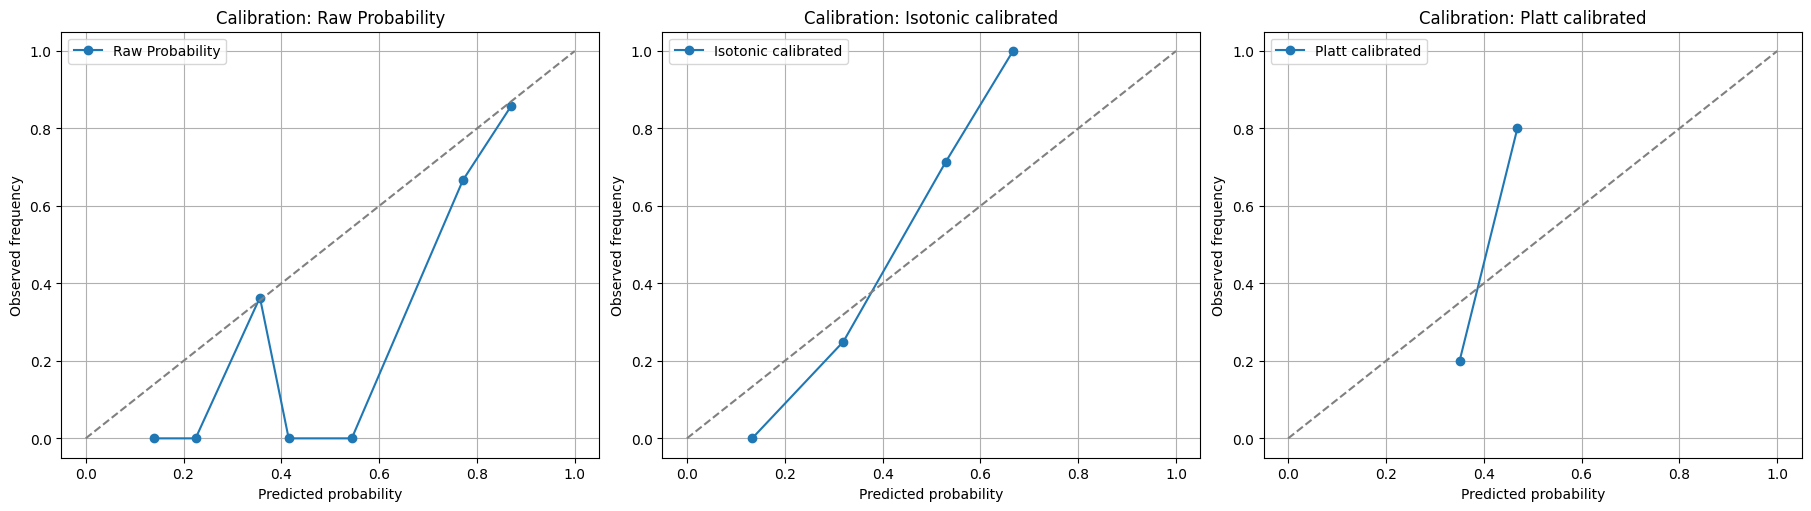

In [13]:
# Calibration curves separately
def plot_calibration(name, probs, labels, ax):
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10, strategy="uniform")
    ax.plot(prob_pred, prob_true, marker="o", label=f"{name}")
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Observed frequency")
    ax.set_title(f"Calibration: {name}")
    ax.grid(True)
    ax.legend()

fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
plot_calibration("Raw Probability", X_test["replication_probability"].values, y_test, axs[0])
plot_calibration("Isotonic calibrated", calibrated_iso, y_test, axs[1])
plot_calibration("Platt calibrated", calibrated_platt, y_test, axs[2])
plt.show()